# Climate Data Analysis


# Loading and cleaning data for further analysis.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Load the dataset
file_path = 'Data/GlobalLandTemperaturesByCountry.csv'
data = pd.read_csv(file_path)

# Display the first few rows and basic information about the dataset
data.head(), data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


(           dt  AverageTemperature  AverageTemperatureUncertainty Country
 0  1743-11-01               4.384                          2.294   Åland
 1  1743-12-01                 NaN                            NaN   Åland
 2  1744-01-01                 NaN                            NaN   Åland
 3  1744-02-01                 NaN                            NaN   Åland
 4  1744-03-01                 NaN                            NaN   Åland,
 None,
        AverageTemperature  AverageTemperatureUncertainty
 count       544811.000000                  545550.000000
 mean            17.193354                       1.019057
 std             10.953966                       1.201930
 min            -37.658000                       0.052000
 25%             10.025000                       0.323000
 50%             20.901000                       0.571000
 75%             25.814000                       1.206000
 max             38.842000                      15.003000)

/var/folders/qm/m2j4gyxn6d3dvqq5n3d91kxr0000gn/T/ipykernel_12954/2805148115.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data.set_index('dt')['AverageTemperature'].isnull().resample('Y').sum().plot(ax=ax)


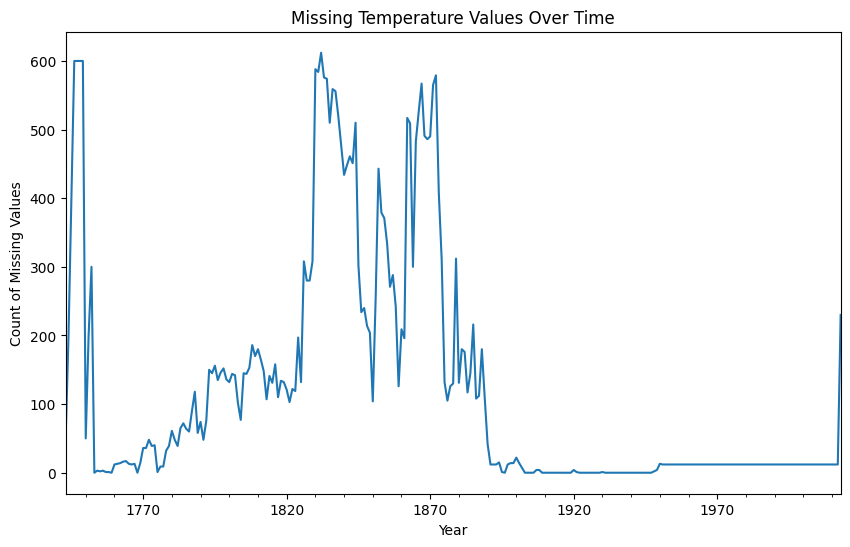

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [2]:
# Convert 'dt' column to datetime format
data['dt'] = pd.to_datetime(data['dt'])

# Check for missing values
missing_values = data.isnull().sum()

# Plot missing values over time
fig, ax = plt.subplots(figsize=(10, 6))
data.set_index('dt')['AverageTemperature'].isnull().resample('Y').sum().plot(ax=ax)
ax.set_title('Missing Temperature Values Over Time')
ax.set_ylabel('Count of Missing Values')
ax.set_xlabel('Year')
plt.show()

missing_values

In [3]:
# Filter out data prior to 1900 due to sparsity and inaccuracy
data_filtered = data[data['dt'].dt.year >= 1900]

# Check the missing data count after filtering
data_filtered.head(), data_filtered.isnull().sum()

(             dt  AverageTemperature  AverageTemperatureUncertainty Country
 1874 1900-01-01              -3.026                          0.538   Åland
 1875 1900-02-01              -8.063                          0.657   Åland
 1876 1900-03-01              -3.196                          0.467   Åland
 1877 1900-04-01               0.781                          0.224   Åland
 1878 1900-05-01               4.960                          0.503   Åland,
 dt                                  0
 AverageTemperature               1050
 AverageTemperatureUncertainty     311
 Country                             0
 dtype: int64)

In [4]:
# Applying linear interpolation using .loc to ensure changes are properly registered
data_filtered.loc[:, 'AverageTemperature'] = data_filtered['AverageTemperature'].interpolate(method='linear')
data_filtered.loc[:, 'AverageTemperatureUncertainty'] = data_filtered['AverageTemperatureUncertainty'].interpolate(method='linear')

# Recheck the dataset to ensure the operation was successful
data_filtered.isnull().sum(), data_filtered.head()

(dt                               0
 AverageTemperature               0
 AverageTemperatureUncertainty    0
 Country                          0
 dtype: int64,
              dt  AverageTemperature  AverageTemperatureUncertainty Country
 1874 1900-01-01              -3.026                          0.538   Åland
 1875 1900-02-01              -8.063                          0.657   Åland
 1876 1900-03-01              -3.196                          0.467   Åland
 1877 1900-04-01               0.781                          0.224   Åland
 1878 1900-05-01               4.960                          0.503   Åland)

### Loading GHG Emissions Data

In [7]:
# Load the dataset
ghg_file_path = 'Data/EmissionsData.csv'
ghg_data = pd.read_csv(ghg_file_path, header=None)

# Transpose the DataFrame
ghg_data = ghg_data.T

# Set the first row as column names
ghg_data.columns = ghg_data.iloc[0]

# Drop the first row
ghg_data = ghg_data.drop(0)

ghg_data.rename(columns={'Country': 'Year'}, inplace=True)



# Extract the 'World' emissions row (assumes the 'countries' column was the first column in the original data)
world_data = ghg_data[['Year', 'World']].copy()

# Convert data types
world_data['Year'] = world_data['Year'].astype(int)
world_data['World'] = world_data['World'].astype(float)
world_data = world_data[world_data['Year'] >= 1900].reset_index(drop=True)

world_data.rename(columns={'World': 'Global GHG Emissions'}, inplace=True)


# Display the first few rows to verify
print(world_data.head())



0  Year  Global GHG Emissions
0  1900          4.482107e+10
1  1901          4.683904e+10
2  1902          4.890813e+10
3  1903          5.116540e+10
4  1904          5.344663e+10


### Merging GHG Emissions df with global avg temp

In [29]:
# merged_data = pd.merge(global_avg_temp_per_year, avg_ghg_per_year, on='Year')
merged_data = pd.merge(global_avg_temp_per_year, world_data, on='Year')

# Display the first few rows to verify the merge
print(merged_data.head())

   Year  GlobalAverageTemperature  Global GHG Emissions
0  1900                 18.539583          4.482107e+10
1  1901                 18.525636          4.683904e+10
2  1902                 18.340054          4.890813e+10
3  1903                 18.434771          5.116540e+10
4  1904                 18.211075          5.344663e+10


# Exploratory Data Analysis (EDA)

### Visualising temperature trends globally and country-specific over time.

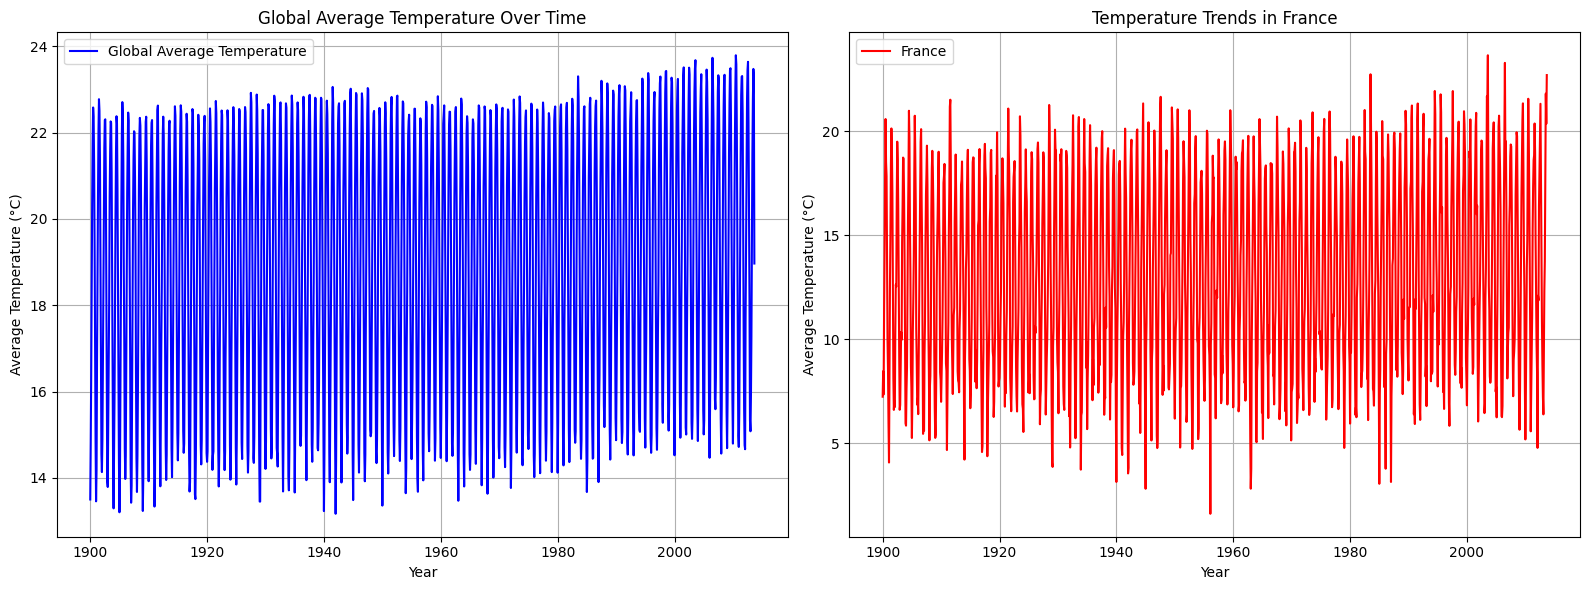

In [9]:
# Calculate Global Average Temperature per month
global_avg_temp = data_filtered.groupby('dt')['AverageTemperature'].mean()
# Filter data for France
france_avg_temp = data_filtered[data_filtered['Country'] == 'France'].groupby('dt')['AverageTemperature'].mean()

# Setting up the plots side-by-side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Global Average Temperature
ax[0].plot(global_avg_temp.index, global_avg_temp, label='Global Average Temperature', color='blue')
ax[0].set_title('Global Average Temperature Over Time')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Average Temperature (°C)')
ax[0].legend()
ax[0].grid(True)

# Plot for France Temperature Trends
ax[1].plot(france_avg_temp.index, france_avg_temp, label='France', color='red')
ax[1].set_title('Temperature Trends in France')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Average Temperature (°C)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()



# Statistical analysis

### Calculating means, medians, variances, and other descriptive statistics for temperatures over time.

In [10]:
global_stats = global_avg_temp.describe()
print("Global Temperature Descriptive Statistics:")
print(global_stats)

Global Temperature Descriptive Statistics:
count    1365.000000
mean       18.848706
std         3.051220
min        13.169671
25%        16.048224
50%        19.112125
75%        21.752063
max        23.792102
Name: AverageTemperature, dtype: float64


In [11]:
france_stats = france_avg_temp.describe()
print("France Temperature Descriptive Statistics:")
print(france_stats)

France Temperature Descriptive Statistics:
count    1365.000000
mean       13.067885
std         4.749323
min         1.602000
25%         8.869000
50%        12.746000
75%        17.505000
max        23.662000
Name: AverageTemperature, dtype: float64


In [12]:
# Skewness and Kurtosis
global_skewness = global_avg_temp.skew()
global_kurtosis = global_avg_temp.kurt()

print("\nAdditional Global Statistics:")
print(f"Skewness: {global_skewness}")
print(f"Kurtosis: {global_kurtosis}")

france_skewness = france_avg_temp.skew()
france_kurtosis = france_avg_temp.kurt()

print("\nAdditional France Statistics:")
print(f"Skewness: {france_skewness}")
print(f"Kurtosis: {france_kurtosis}")



Additional Global Statistics:
Skewness: -0.16564873038142439
Kurtosis: -1.3902615727500538

Additional France Statistics:
Skewness: 0.027116700455616125
Kurtosis: -1.2144075940458017


### Calculating the same descriptive statistics for the temperature depending on the GHG Emissions Data

In [46]:
GHGemission_stats = merged_data.describe()
print("Global Temperature Descriptive Statistics:")
print(GHGemission_stats)
##Change the way it appears ?

Global Temperature Descriptive Statistics:
              Year  GlobalAverageTemperature  Global GHG Emissions
count   114.000000                114.000000          1.140000e+02
mean   1956.500000                 18.850705          4.421447e+11
std      33.052988                  0.358949          3.906130e+11
min    1900.000000                 18.148444          4.482107e+10
25%    1928.250000                 18.620882          1.330000e+11
50%    1956.500000                 18.807512          2.760000e+11
75%    1984.750000                 18.976983          6.910000e+11
max    2013.000000                 19.742711          1.430000e+12


In [47]:
# Skewness and Kurtosis
GHGemission_skewness = GHGemission_stats['Global GHG Emissions'].skew()
GHGemission_kurtosis = GHGemission_stats['Global GHG Emissions'].kurt()

print("\nAdditional GHG emissions Statistics:")
print(f"Skewness: {GHGemission_skewness}")
print(f"Kurtosis: {GHGemission_kurtosis}")


Additional GHG emissions Statistics:
Skewness: 1.6453528524870185
Kurtosis: 3.0293401935834643


### Correlation Matrix of Global Average Temperature and GHG Emissions

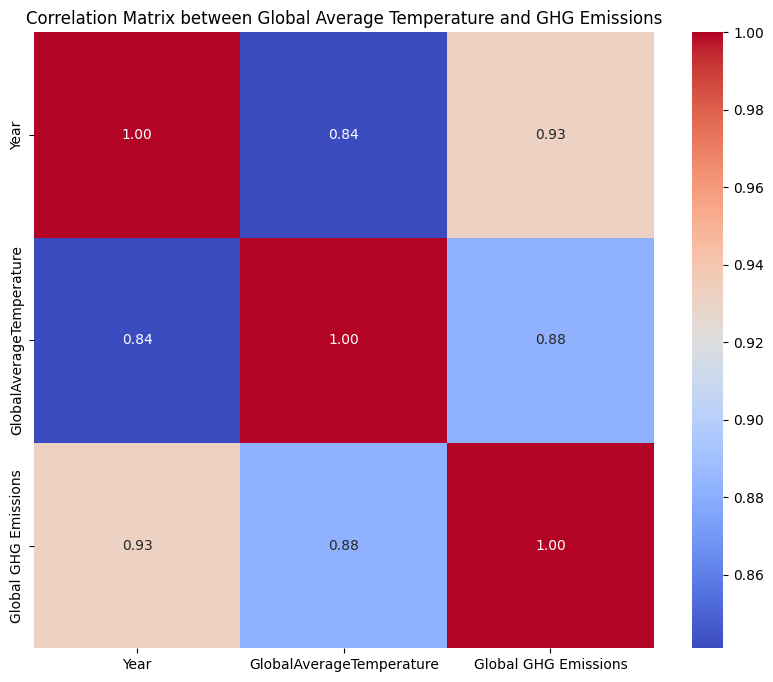

In [27]:
# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Global Average Temperature and GHG Emissions')
plt.show()


### First Null Hypothesis (H0): There is no significant difference in the mean temperatures across the specified decades.

In [66]:
# Suppress the SettingWithCopyWarning for the next operation
pd.options.mode.chained_assignment = None

# Creating a new column 'decade' for the decade-wise segregation
data_filtered.loc[:, 'decade'] = (data_filtered['dt'].dt.year // 10) * 10

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(
    data_filtered[data_filtered['decade'] == 1900]['AverageTemperature'],
    data_filtered[data_filtered['decade'] == 1950]['AverageTemperature'],
    data_filtered[data_filtered['decade'] == 2000]['AverageTemperature'],
    data_filtered[data_filtered['decade'] == 2010]['AverageTemperature'],
)

# Re-enable the SettingWithCopyWarning for subsequent operations
pd.options.mode.chained_assignment = 'warn'

print("ANOVA test results:")
print(f"F-Statistic: {f_value}, P-value: {p_value}")

ANOVA test results:
F-Statistic: 65.62163886366625, P-value: 3.7598579560105626e-31


F-Statistic: A value of 74.14 suggests that there is a significant difference in means between the groups (decades). \
P-Value: The p-value is extremely low (6.84e-48), indicating that the observed difference in means is highly statistically significant. \
Since the p-value is much less than the common alpha level of 0.05 (or even 0.01), we reject the null hypothesis that all group means are the same. \
However, I will check K-S and Levene's test to conclude if ANOVA assumptions are violated.

In [14]:
# Perform Kolmogorov-Smirnov test for normality for each decade
for decade in data_filtered['decade'].unique():
    temperature_data = data_filtered[data_filtered['decade'] == decade]['AverageTemperature']
    stat, p = stats.kstest(temperature_data, 'norm', args=(temperature_data.mean(), temperature_data.std()))
    print(f"K-S Test for the {decade}s: Stat={stat}, p-value={p}")

K-S Test for the 1900s: Stat=0.1645075642482115, p-value=0.0
K-S Test for the 1910s: Stat=0.16610945340192573, p-value=0.0
K-S Test for the 1920s: Stat=0.1671755775061355, p-value=0.0
K-S Test for the 1930s: Stat=0.1661240531843955, p-value=0.0
K-S Test for the 1940s: Stat=0.16599126959331695, p-value=0.0
K-S Test for the 1950s: Stat=0.16481979461458363, p-value=0.0
K-S Test for the 1960s: Stat=0.1653229359012484, p-value=0.0
K-S Test for the 1970s: Stat=0.16622968928484538, p-value=0.0
K-S Test for the 1980s: Stat=0.1668470305872154, p-value=0.0
K-S Test for the 1990s: Stat=0.16655872317057363, p-value=0.0
K-S Test for the 2000s: Stat=0.16465075085174108, p-value=0.0
K-S Test for the 2010s: Stat=0.16668240894297126, p-value=5.250666198353818e-266


In [15]:
# Check homogeneity of variance
decade_groups = [data_filtered[data_filtered['decade'] == decade]['AverageTemperature'] for decade in data_filtered['decade'].unique()]
stat, p = stats.levene(*decade_groups)
print(f"Levene’s Test: Stat={stat}, p-value={p}")

Levene’s Test: Stat=1.503821842992586, p-value=0.12217684654645541


In the context of hypothesis testing, the null hypothesis states that there are no differences between group means. Despite the significant F-statistic and p-value from the ANOVA, which would typically lead us to reject the null hypothesis and conclude that there are indeed differences between the decade temperature means, the violations of ANOVA assumptions mean we should be cautious with this conclusion.

In [16]:
# Perform Kruskal-Wallis test
kruskal_stats, kruskal_p = stats.kruskal(
    *[data_filtered[data_filtered['decade'] == decade]['AverageTemperature'] for decade in data_filtered['decade'].unique()]
)

print(f"Kruskal-Wallis Test: H-Statistic={kruskal_stats}, p-value={kruskal_p}")

Kruskal-Wallis Test: H-Statistic=1053.8190297859212, p-value=4.9977953353919165e-219


We can now confidently reject the first null hypothesis.

### Second Null Hypothesis (H0): There is no significative difference between the mean temperatures depending on the global ghg emissions

In [73]:
# Suppress the SettingWithCopyWarning for the next operation
pd.options.mode.chained_assignment = None

# Creating a new column 'power' for the decade-wise segregation
merged_data.loc[:, 'power'] = (merged_data['Global GHG Emissions'] // 1e+11)

# Perform one-way ANOVA using loc to avoid reindexing issues
f_value, p_value = stats.f_oneway(
    merged_data.loc[merged_data['power'] <= 4, 'GlobalAverageTemperature'],
    merged_data.loc[(merged_data['power'] > 4) & (merged_data['power'] <= 9), 'GlobalAverageTemperature'],
    merged_data.loc[(merged_data['power'] > 9) & (merged_data['power'] <= 14), 'GlobalAverageTemperature'],
   )

# Re-enable the SettingWithCopyWarning for subsequent operations
pd.options.mode.chained_assignment = 'warn'

print("ANOVA test results:")
print(f"F-Statistic: {f_value}, P-value: {p_value}")

ANOVA test results:
F-Statistic: 126.11423338855235, P-value: 2.6634351114902907e-29


Same observation as for the first null hypothesis: high F statistic and low P-value indicate an important difference between the means of the "power" groups

In [74]:
# Perform Kolmogorov-Smirnov test for normality for each power group
for power in merged_data['power'].unique():
    temperature_data = merged_data[merged_data['power'] == power]['GlobalAverageTemperature']
    stat, p = stats.kstest(temperature_data, 'norm', args=(temperature_data.mean(), temperature_data.std()))
    print(f"K-S Test for the {power}s: Stat={stat}, p-value={p}")

K-S Test for the 0.0s: Stat=0.09257612385258152, p-value=0.9890782262140032
K-S Test for the 1.0s: Stat=0.13299974024757516, p-value=0.7409163955478884
K-S Test for the 2.0s: Stat=0.1519605439129006, p-value=0.8017633801989574
K-S Test for the 3.0s: Stat=0.20699758556576836, p-value=0.7641233459565692
K-S Test for the 4.0s: Stat=0.19307916363492977, p-value=0.9468610868446486
K-S Test for the 5.0s: Stat=0.2356221518743839, p-value=0.8862051078238551
K-S Test for the 6.0s: Stat=0.19348685245257757, p-value=0.9460559170769818
K-S Test for the 7.0s: Stat=0.38029729076459007, p-value=0.5017406325102929
K-S Test for the 8.0s: Stat=0.28589391148633003, p-value=0.7188545186803075
K-S Test for the 9.0s: Stat=0.25092215412862545, p-value=0.9041662431989088
K-S Test for the 10.0s: Stat=0.2836711682910337, p-value=0.819563410757061
K-S Test for the 11.0s: Stat=0.290980210214788, p-value=0.9077860605391788
K-S Test for the 12.0s: Stat=0.2993604883674432, p-value=0.7727773917682419
K-S Test for the

Here, the Kolmogorov-Smirnov indicates that the data is not normally distributed. Thus we need to try another test to reject the null hypothesis.

In [75]:
# Perform Kruskal-Wallis test
kruskal_stats, kruskal_p = stats.kruskal(
    *[merged_data[merged_data['power'] == power]['GlobalAverageTemperature'] for power in merged_data['power'].unique()]
)

print(f"Kruskal-Wallis Test: H-Statistic={kruskal_stats}, p-value={kruskal_p}")

Kruskal-Wallis Test: H-Statistic=85.6230536486143, p-value=2.529240381166453e-12


Again, this test allows us to reject the second null hypothesis.

Hence, there is a correlation between the years and the temperatures, and between the ghg emissions and the temperatures. This justify the use of models to predict temperatures for a given year or for a given amount of ghg emissions.

# Regression analysis

### Linear regression model for global average temperatures over time.

In [17]:
# Prepare the data
X = np.array(data_filtered['dt'].dt.year).reshape(-1, 1)  # Reshape for sklearn
y = data_filtered['AverageTemperature'].values

# Create and fit the model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Print the coefficients
print(f"Coefficient: {linear_model.coef_[0]}")
print(f"Intercept: {linear_model.intercept_}")

Coefficient: 0.009098477187548465
Intercept: 1.0483373913037788


Coefficient: 0.01066. \
This value represents the estimated change in average temperature (in degrees Celsius) for each additional year.

Intercept: -2.021. \
This is the point where the regression line intercepts the y-axis of the graph. In terms of the model, it represents the predicted value of the dependent variable (in this case, average temperature) when all independent variables (in this case, time as the year) are set to zero.

The positive coefficient suggests a long-term trend of rising temperatures, which is consistent with what is generally understood about global warming. For each year, the model predicts an increase in the global average temperature of about 0.01066°C.

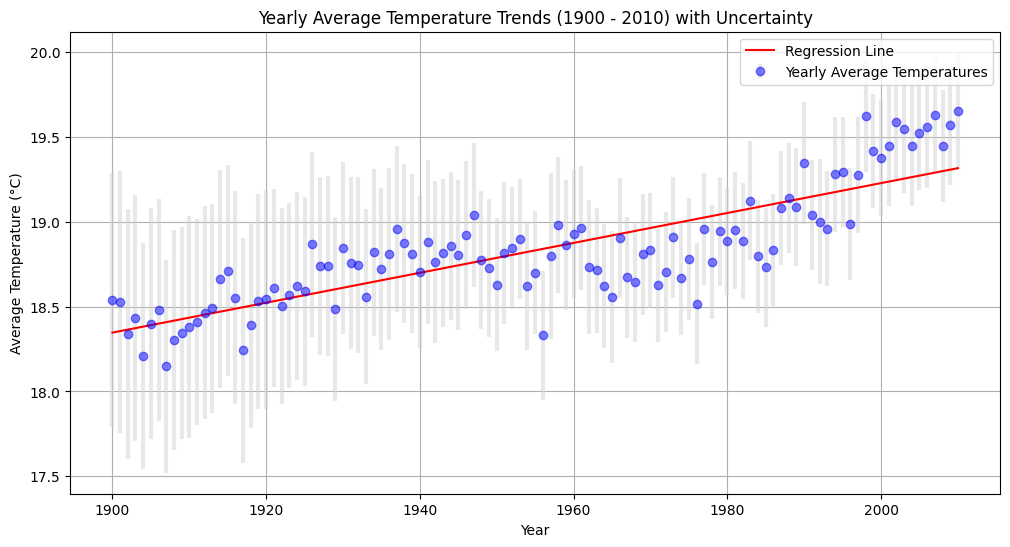

In [18]:
# Filter data within the year range and ensure no NaN values in 'AverageTemperature' and 'AverageTemperatureUncertainty'
data_reg = data_filtered[(data_filtered['dt'].dt.year >= 1900) & (data_filtered['dt'].dt.year <= 2010)]
data_reg = data_reg.dropna(subset=['AverageTemperature', 'AverageTemperatureUncertainty'])

# Calculate yearly averages and uncertainty
yearly_data = data_reg.groupby(data_reg['dt'].dt.year).agg({
    'AverageTemperature': 'mean',
    'AverageTemperatureUncertainty': 'mean'
}).reset_index()
yearly_data.rename(columns={'dt': 'Year', 'AverageTemperature': 'YearlyAverageTemp', 'AverageTemperatureUncertainty': 'YearlyUncertainty'}, inplace=True)

# Prepare the data for regression
X = yearly_data['Year'].values.reshape(-1, 1)
y = yearly_data['YearlyAverageTemp'].values

# Create and fit the model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Generate predictions for the plot
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_plot = linear_model.predict(X_plot)

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(X, y, yerr=yearly_data['YearlyUncertainty'].values, fmt='o', color='blue', label='Yearly Average Temperatures', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0)
plt.plot(X_plot, y_plot, color='red', label='Regression Line')
plt.title('Yearly Average Temperature Trends (1900 - 2010) with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
data_filtered['Year'] = data_filtered['dt'].dt.year
global_avg_temp_per_year = data_filtered.groupby('Year')['AverageTemperature'].mean().reset_index()

# Rename the column for clarity
global_avg_temp_per_year.rename(columns={'AverageTemperature': 'GlobalAverageTemperature'}, inplace=True)

# Display the first few rows to verify
print(global_avg_temp_per_year.head())

   Year  GlobalAverageTemperature
0  1900                 18.539583
1  1901                 18.525636
2  1902                 18.340054
3  1903                 18.434771
4  1904                 18.211075


/var/folders/qm/m2j4gyxn6d3dvqq5n3d91kxr0000gn/T/ipykernel_12954/1379771688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Year'] = data_filtered['dt'].dt.year


# ML predictions: Decision Tree and Random Forest

In [21]:
#data_filtered = data_filtered.sample(frac=0.1, random_state=42)
# Convert 'dt' to datetime
data_filtered['dt'] = pd.to_datetime(data_filtered['dt'])

# Extract year and month from 'dt'
data_filtered['year'] = data_filtered['dt'].dt.year
data_filtered['month'] = data_filtered['dt'].dt.month

# Define features and target variable
X = data_filtered[['AverageTemperatureUncertainty', 'Country', 'decade', 'year', 'month']]
y = data_filtered['AverageTemperature']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/qm/m2j4gyxn6d3dvqq5n3d91kxr0000gn/T/ipykernel_12954/4000885563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['dt'] = pd.to_datetime(data_filtered['dt'])
/var/folders/qm/m2j4gyxn6d3dvqq5n3d91kxr0000gn/T/ipykernel_12954/4000885563.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['year'] = data_filtered['dt'].dt.year
/var/folders/qm/m2j4gyxn6d3dvqq5n3d91kxr0000gn/T/ipykernel_12954/4000885563.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [23]:
emission_data = "Data/EmissionsData.csv"
ghg_data_emition_data = pd.read_csv(emission_data)
ghg_data_emition_data.head()

,Country,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,8.515264e+07,9.191295e+07,1.003652e+08,1.125912e+08,1.233332e+08,1.333337e+08,1.431228e+08,1.532303e+08,1.654882e+08,1.785029e+08
1,Africa,0,0,0,0,0,0,0,0,0,...,3.183077e+10,3.301904e+10,3.421283e+10,3.541120e+10,3.664504e+10,3.789569e+10,3.918617e+10,4.047518e+10,4.178583e+10,4.311757e+10
2,Albania,0,0,0,0,0,0,0,0,0,...,2.287948e+08,2.331696e+08,2.377643e+08,2.430001e+08,2.479062e+08,2.529662e+08,2.586784e+08,2.646261e+08,2.708990e+08,2.772782e+08
3,Algeria,0,0,0,0,0,0,0,0,0,...,2.894820e+09,3.015005e+09,3.132819e+09,3.252626e+09,3.380736e+09,3.513171e+09,3.656348e+09,3.806940e+09,3.957319e+09,4.107870e+09
4,Americas (other),0,0,0,0,0,0,0,0,0,...,7.746025e+10,7.961787e+10,8.187178e+10,8.416656e+10,8.654197e+10,8.894874e+10,9.139192e+10,9.382747e+10,9.624253e+10,9.864116e+10


In [24]:
# Convert emissions data to long format
df_emissions_long = ghg_data_emition_data.melt(id_vars=['Country'], var_name='year', value_name='emissions')
df_emissions_long['year'] = df_emissions_long['year'].astype(int)

# Merge datasets on Country and Year
merged_df = pd.merge(data_filtered, df_emissions_long, on=['Country', 'year'], how='left')

In [25]:
merged_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,Year,decade,emissions
0,1900-01-01,-3.026,0.538,Åland,1900,1,1900,1900,NaN
1,1900-02-01,-8.063,0.657,Åland,1900,2,1900,1900,NaN
2,1900-03-01,-3.196,0.467,Åland,1900,3,1900,1900,NaN
3,1900-04-01,0.781,0.224,Åland,1900,4,1900,1900,NaN
4,1900-05-01,4.960,0.503,Åland,1900,5,1900,1900,NaN


In [26]:
# Handle missing values in 'emissions' by imputing the mean
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['emissions']),
    ], remainder='passthrough'
)

# Split the data into features and target
X = merged_df[['year', 'month', 'emissions']]
y = merged_df['AverageTemperature']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Train models and evaluate
results = {}
for name, model in models.items():
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse
    print(f"{name}: MSE = {mse:.4f}")



Decision Tree: MSE = 92.0394
Random Forest: MSE = 75.1099


In [66]:
# Select the best model based on MSE
best_model_name = min(results, key=results.get)
best_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[best_model_name])])
best_model_pipeline.fit(X_train, y_train)
print(f"The best model is {best_model_name} with an MSE of {results[best_model_name]:.4f}")

The best model is Random Forest with an MSE of 75.1113


In [79]:
# Predicting a new temperature
new_data = pd.DataFrame({
    'AverageTemperatureUncertainty': [1.5, 2.0],
    'Country': ['United States', 'Canada'],
    'decade': [2020, 2020],
    'year': [2024, 2025],
    'month': [6, 7],
    'emissions' : [3096302236, 3096302236]
})

predicted_temp = best_model_pipeline.predict(new_data)
print(f"Predicted temperature for new data: {predicted_temp[0]:.4f}")
print(f"Predicted temperature for new data: {predicted_temp[1]:.4f}")

Predicted temperature for new data: 30.2305
Predicted temperature for new data: 30.4628
